In [1]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as t
import matplotlib as plt
import seaborn as sns

import pandas as pd

import openpyxl
import math 
from scipy import stats
import arviz as az

In [67]:
df = pd.read_excel(r"C:\Users\eart0477\1. Work files\1. Postdoc work\Bubble point\bubble point ruta inversion.xlsx", header=0, index_col=0, sheet_name='python')

df=df[['Model', '20Ne/36Ar', '84Kr/36Ar', '130Xe/36Ar', 'Alpha_NeAr', 'Alpha_KrAr', 'Alpha_XeAr', 'Temp' , 'N2', '20Ne', '36Ar', '84Kr', '130Xe']]

kf = df.loc[df['Model'] == 'KrXe']
airf = df.loc[df['Model'] == 'excess air/dissolution']



In [68]:
#selecting variables for dataframe

dataframe = kf
sample_id = dataframe.index
coords = { "sample_id": sample_id}
Temp = np.array(dataframe['Temp'])
Alpha_NeAr = np.array(dataframe['Alpha_NeAr'])
Alpha_KrAr = np.array(dataframe['Alpha_KrAr'])
Alpha_XeAr = np.array(dataframe['Alpha_XeAr'])
NeAr_d1 = np.array(dataframe['20Ne/36Ar'])
KrAr_d1 = np.array(dataframe['84Kr/36Ar'])
XeAr_d1 = np.array(dataframe['130Xe/36Ar'])



In [82]:
print(KrAr_d1)

[0.04519882 0.05421375 0.04185702 0.0471047  0.02496805 0.05702607
 0.0528005  0.04082373]


In [38]:
def model_dissolution():
    with pm.Model(coords=coords) as model: 
    
        #t = pm.Normal('t', 273.15+15, 5,  dims='sample_id')
        t= 273.15+15
        #Ef =pm.Normal('Ef', 1, 1,  dims='sample_id')
        F = 0
        F_d = pm.Uniform('F_d',0,1, dims='sample_id')
        Ef=1

        NeAr_d = pm.Data("NeAr_d", NeAr_d1, dims=("sample_id"))
        KrAr_d = pm.Data("KrAr_d", KrAr_d1, dims=("sample_id"))
        XeAr_d = pm.Data("XeAr_d", XeAr_d1, dims=("sample_id"))




        Na=0

        h=0

        # Setchenow coefficients for solublity dependence on salinity Smith and Kennedy (1983) (ones in the bible are slightly different)
        She = (-9.6723) + (14.4725) / (t / 100) + 4.6188 * np.log(t / 100)
        Sne = (-11.525) + (17.7408) / (t / 100) + 5.3421 * np.log(t / 100)
        Sar = (-10.271) + (16.095) / (t / 100) + 4.7539 * np.log(t / 100)
        Skr = (-9.5534) + (15.1039) / (t / 100) + 4.4164 * np.log(t / 100)
        Sxe = (-14.1338) + (21.8772) / (t / 100) + 6.5527 * np.log(t / 100)
        S = np.array([She, Sne, Sar, Skr, Sxe])

        # salinity constant Sr = e^S*Na
        Sr = np.exp(S * Na)

        # Humidity correction assuming 100% humidity at the water-air exchange surface PH20 is in mTorr. 760 mTorr = 1 atm
        #PH2O = np.exp((-5375.83583 / t) + 21.2023734)

        # Altitude correction P=P0exp(-h/8350)
        p_corr = (np.exp(-h/8350))
        #water vapour correction
        PH2O = np.exp((-5375.83583 / t) + 21.2023734)
        v_corr = (760 - PH2O)/760


        #Vapour pressure calculations wagner et puss 1993

        Pc=0.022064
        a1=-7.85951783
        a2=1.84408259
        a3=-11.7866497
        a4=22.6807411
        a5=-15.9618719
        a6=1.80122502
        Tc=647.096 #Critical point of water
        P=2.34e-6
        #Tr = Tc/t
        t1 = 1-(t/Tc)


        Tr = t/Tc
        t2 = (1-Tr)

        #vapour pressure in GPA
        P=Pc*np.exp((Tc/t)*((a1*t1)+(a2*(t1**1.5))+(a3*(t1**3))+(a4*(t1**3.5))+(a5*(t1**4))+(a6*(t1**7.5))))


        #Henry K Fernandez-Prini et al 2003. 5x3 matrix flipped to be 3x5. He, Ne, Ar, Kr, Xe coefficients in separate columns
        FK = np.array([[-3.52839, 7.12983, 4.4777],
             [-3.18301, 5.31448, 5.43774],
             [-8.40954, 4.29587, 10.52779],
             [-8.97358,3.61508,11.29963],
                [-14.21635,4.00041,15.60999]])

 

      
       
        air = [5.24e-6, 1.645e-5, 3.142e-5, 6.498e-7, 3.54e-9 ]

        #Henry K in atm and corrected for salinity
        
        khe= (((P*np.exp(FK[0,0]/Tr+((FK[0,1]*t2**0.355/Tr)+FK[0,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sne * Na))
              / 0.000101325)/(p_corr*v_corr)
        
        kne= (((P*np.exp(FK[1,0]/Tr+((FK[1,1]*t2**0.355/Tr)+FK[1,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sne * Na)) / 0.000101325)/(p_corr*v_corr)
        kar= (((P*np.exp(FK[2,0]/Tr+((FK[2,1]*t2**0.355/Tr)+FK[2,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sar * Na)) / 0.000101325)/(p_corr*v_corr)
        kkr= (((P*np.exp(FK[3,0]/Tr+((FK[3,1]*t2**0.355/Tr)+FK[3,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Skr * Na)) / 0.000101325)/(p_corr*v_corr)
        kxe= (((P*np.exp(FK[4,0]/Tr+((FK[4,1]*t2**0.355/Tr)+FK[4,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sxe * Na)) / 0.000101325)/(p_corr*v_corr)

        Ne_asw = (air[1]/kne + (air[1]*F))
        Ar_asw = (air[2]/kar + (air[2]*F)) 
        Kr_asw = (air[3]/kkr + (air[3]*F))
        Xe_asw = (air[4]/kxe +(air[4] * F))
       

        NeAr = Ne_asw/Ar_asw
        KrAr = (Kr_asw * Ef) /Ar_asw
        XeAr = (Xe_asw * Ef) /Ar_asw




        ne_mod = pm.Deterministic('ne_mod', var=NeAr * F_d ** (1/Alpha_NeAr-1), dims='sample_id')
        kr_mod = pm.Deterministic('kr_mod', var=KrAr * F_d ** (1/Alpha_KrAr-1), dims='sample_id')
        xe_mod = pm.Deterministic('xe_mod', var=XeAr * F_d ** (1/Alpha_XeAr-1), dims='sample_id')

        ne_f = pm.Normal('ne_f', mu=ne_mod, sd=1e-3, dims='sample_id', observed = NeAr_d)
        kr_f = pm.Normal('kr_f', mu=kr_mod, sd=1e-3, dims='sample_id', observed = KrAr_d)
        xe_f = pm.Normal('xe_f', mu=xe_mod, sd=0.001, dims='sample_id', observed =XeAr_d)

    return model








In [35]:
def model_excess_air():
    with pm.Model(coords=coords) as model: 
    
        #t = pm.Normal('t', 273.15+15, 5,  dims='sample_id')
        t= 273.15+10
        #Ef =pm.Normal('Ef', 1, 1,  dims='sample_id')
        F = pm.Uniform('F',0, 1, dims='sample_id')
        #sd1 = pm.HalfNormal('sd1', 0.2, dims='sample_id')
        #sd2 = pm.HalfNormal('sd2', 0.05, dims='sample_id')
        #sd3 = pm.HalfNormal('sd3', 0.005, dims='sample_id')
        #Ef=2
        #F=0
        

        NeAr_d = pm.Data("NeAr_d", NeAr_d1, dims=("sample_id"))
        KrAr_d = pm.Data("KrAr_d", KrAr_d1, dims=("sample_id"))
        XeAr_d = pm.Data("XeAr_d", XeAr_d1, dims=("sample_id"))




        Na=0

        h=0

        # Setchenow coefficients for solublity dependence on salinity Smith and Kennedy (1983) (ones in the bible are slightly different)
        She = (-9.6723) + (14.4725) / (t / 100) + 4.6188 * np.log(t / 100)
        Sne = (-11.525) + (17.7408) / (t / 100) + 5.3421 * np.log(t / 100)
        Sar = (-10.271) + (16.095) / (t / 100) + 4.7539 * np.log(t / 100)
        Skr = (-9.5534) + (15.1039) / (t / 100) + 4.4164 * np.log(t / 100)
        Sxe = (-14.1338) + (21.8772) / (t / 100) + 6.5527 * np.log(t / 100)
        S = np.array([She, Sne, Sar, Skr, Sxe])

        # salinity constant Sr = e^S*Na
        Sr = np.exp(S * Na)

        # Humidity correction assuming 100% humidity at the water-air exchange surface PH20 is in mTorr. 760 mTorr = 1 atm
        #PH2O = np.exp((-5375.83583 / t) + 21.2023734)

        # Altitude correction P=P0exp(-h/8350)
        p_corr = (np.exp(-h/8350))
        #water vapour correction
        PH2O = np.exp((-5375.83583 / t) + 21.2023734)
        v_corr = (760 - PH2O)/760


        #Vapour pressure calculations wagner et puss 1993

        Pc=0.022064
        a1=-7.85951783
        a2=1.84408259
        a3=-11.7866497
        a4=22.6807411
        a5=-15.9618719
        a6=1.80122502
        Tc=647.096 #Critical point of water
       
        #Tr = Tc/t
        t1 = 1-(t/Tc)


        Tr = t/Tc
        t2 = (1-Tr)

        #vapour pressure in GPA
        P=Pc*np.exp((Tc/t)*((a1*t1)+(a2*(t1**1.5))+(a3*(t1**3))+(a4*(t1**3.5))+(a5*(t1**4))+(a6*(t1**7.5))))


        #Henry K Fernandez-Prini et al 2003. 5x3 matrix flipped to be 3x5. He, Ne, Ar, Kr, Xe coefficients in separate columns
        FK = np.array([[-3.52839, 7.12983, 4.4777],
             [-3.18301, 5.31448, 5.43774],
             [-8.40954, 4.29587, 10.52779],
             [-8.97358,3.61508,11.29963],
                [-14.21635,4.00041,15.60999]])

        air = [5.24e-6, 1.645e-5, 3.142e-5, 6.498e-7, 3.54e-9 ]

        #Henry K in atm and corrected for salinity
        
        khe= (((P*np.exp(FK[0,0]/Tr+((FK[0,1]*t2**0.355/Tr)+FK[0,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sne * Na))
              / 0.000101325)/(p_corr*v_corr)
        
        kne= (((P*np.exp(FK[1,0]/Tr+((FK[1,1]*t2**0.355/Tr)+FK[1,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sne * Na)) / 0.000101325)/(p_corr*v_corr)
        kar= (((P*np.exp(FK[2,0]/Tr+((FK[2,1]*t2**0.355/Tr)+FK[2,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sar * Na)) / 0.000101325)/(p_corr*v_corr)
        kkr= (((P*np.exp(FK[3,0]/Tr+((FK[3,1]*t2**0.355/Tr)+FK[3,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Skr * Na)) / 0.000101325)/(p_corr*v_corr)
        kxe= (((P*np.exp(FK[4,0]/Tr+((FK[4,1]*t2**0.355/Tr)+FK[4,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sxe * Na)) / 0.000101325)/(p_corr*v_corr)

        Ne_asw = air[1]/kne *22413.83/18.05
        Ar_asw = air[2]/kar *22413.83/18.05
        Kr_asw = air[3]/kkr *22413.83/18.05
        Xe_asw = air[4]/kxe *22413.83/18.05



        ne_mod = pm.Deterministic('ne_mod', var=((Ne_asw + (air[1]*F))/(Ar_asw + (air[2]*F))) , dims='sample_id')
        kr_mod = pm.Deterministic('kr_mod', var=((Kr_asw + (air[3]*F))/(Ar_asw + (air[2]*F))) , dims='sample_id')
        xe_mod = pm.Deterministic('xe_mod', var=((Xe_asw +(air[4] * F))/(Ar_asw + (air[2]*F)))  , dims='sample_id')

        ne_f = pm.Normal('ne_f', mu=ne_mod, sd=0.001, dims='sample_id', observed = NeAr_d)
        kr_f = pm.Normal('kr_f', mu=kr_mod, sd=0.001, dims='sample_id', observed = KrAr_d)
        xe_f = pm.Normal('xe_f', mu=xe_mod, sd=0.001, dims='sample_id', observed =XeAr_d)
        
        

    return model




    


In [93]:
def excess_kr_xe():
    with pm.Model(coords=coords) as model: 
        
        Ef = pm.Uniform('Ef',1,3, dims='sample_id')
    
        #t = pm.Normal('t', 273.15+15, 5,  dims='sample_id')
        t= 273.15+10
        #Ef =pm.Normal('Ef', 1, 1,  dims='sample_id')
        F = pm.Uniform('F',0, 1, dims='sample_id')
        #sd1 = pm.HalfNormal('sd1', 0.2, dims='sample_id')
        #sd2 = pm.HalfNormal('sd2', 0.05, dims='sample_id')
        #sd3 = pm.HalfNormal('sd3', 0.005, dims='sample_id')
        #Ef=2
        #F=0
        

        NeAr_d = pm.Data("NeAr_d", NeAr_d1, dims=("sample_id"))
        KrAr_d = pm.Data("KrAr_d", KrAr_d1, dims=("sample_id"))
        XeAr_d = pm.Data("XeAr_d", XeAr_d1, dims=("sample_id"))




        Na=0

        h=0

        # Setchenow coefficients for solublity dependence on salinity Smith and Kennedy (1983) (ones in the bible are slightly different)
        She = (-9.6723) + (14.4725) / (t / 100) + 4.6188 * np.log(t / 100)
        Sne = (-11.525) + (17.7408) / (t / 100) + 5.3421 * np.log(t / 100)
        Sar = (-10.271) + (16.095) / (t / 100) + 4.7539 * np.log(t / 100)
        Skr = (-9.5534) + (15.1039) / (t / 100) + 4.4164 * np.log(t / 100)
        Sxe = (-14.1338) + (21.8772) / (t / 100) + 6.5527 * np.log(t / 100)
        S = np.array([She, Sne, Sar, Skr, Sxe])

        # salinity constant Sr = e^S*Na
        Sr = np.exp(S * Na)

        # Humidity correction assuming 100% humidity at the water-air exchange surface PH20 is in mTorr. 760 mTorr = 1 atm
        #PH2O = np.exp((-5375.83583 / t) + 21.2023734)

        # Altitude correction P=P0exp(-h/8350)
        p_corr = (np.exp(-h/8350))
        #water vapour correction
        PH2O = np.exp((-5375.83583 / t) + 21.2023734)
        v_corr = (760 - PH2O)/760


        #Vapour pressure calculations wagner et puss 1993

        Pc=0.022064
        a1=-7.85951783
        a2=1.84408259
        a3=-11.7866497
        a4=22.6807411
        a5=-15.9618719
        a6=1.80122502
        Tc=647.096 #Critical point of water
       
        #Tr = Tc/t
        t1 = 1-(t/Tc)


        Tr = t/Tc
        t2 = (1-Tr)

        #vapour pressure in GPA
        P=Pc*np.exp((Tc/t)*((a1*t1)+(a2*(t1**1.5))+(a3*(t1**3))+(a4*(t1**3.5))+(a5*(t1**4))+(a6*(t1**7.5))))


        #Henry K Fernandez-Prini et al 2003. 5x3 matrix flipped to be 3x5. He, Ne, Ar, Kr, Xe coefficients in separate columns
        FK = np.array([[-3.52839, 7.12983, 4.4777],
             [-3.18301, 5.31448, 5.43774],
             [-8.40954, 4.29587, 10.52779],
             [-8.97358,3.61508,11.29963],
                [-14.21635,4.00041,15.60999]])

        air = [5.24e-6, 1.645e-5, 3.142e-5, 6.498e-7, 3.54e-9 ]

        #Henry K in atm and corrected for salinity
        
        khe= (((P*np.exp(FK[0,0]/Tr+((FK[0,1]*t2**0.355/Tr)+FK[0,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sne * Na))
              / 0.000101325)/(p_corr*v_corr)
        
        kne= (((P*np.exp(FK[1,0]/Tr+((FK[1,1]*t2**0.355/Tr)+FK[1,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sne * Na)) / 0.000101325)/(p_corr*v_corr)
        kar= (((P*np.exp(FK[2,0]/Tr+((FK[2,1]*t2**0.355/Tr)+FK[2,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sar * Na)) / 0.000101325)/(p_corr*v_corr)
        kkr= (((P*np.exp(FK[3,0]/Tr+((FK[3,1]*t2**0.355/Tr)+FK[3,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Skr * Na)) / 0.000101325)/(p_corr*v_corr)
        kxe= (((P*np.exp(FK[4,0]/Tr+((FK[4,1]*t2**0.355/Tr)+FK[4,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sxe * Na)) / 0.000101325)/(p_corr*v_corr)

        Ne_asw = air[1]/kne *22413.83/18.05
        Ar_asw = air[2]/kar *22413.83/18.05
        Kr_asw = air[3]/kkr *22413.83/18.05
        Xe_asw = air[4]/kxe *22413.83/18.05



        ne_mod = pm.Deterministic('ne_mod', var=((Ne_asw + (air[1]*F))/(Ar_asw + (air[2]*F))) , model = model, dims='sample_id')
        kr_mod = pm.Deterministic('kr_mod', var=(((Kr_asw *Ef) + (air[3]*F))/(Ar_asw + (air[2]*F))) , model=model, dims='sample_id')
        xe_mod = pm.Deterministic('xe_mod', var=(((Xe_asw *Ef) +(air[4] * F))/(Ar_asw + (air[2]*F)))  ,model=model, dims='sample_id')

        ne_f = pm.Normal('ne_f', mu=ne_mod, sd=0.001, dims='sample_id', observed = NeAr_d)
        kr_f = pm.Normal('kr_f', mu=kr_mod, sd=0.001, dims='sample_id', observed = KrAr_d)
        xe_f = pm.Normal('xe_f', mu=xe_mod, sd=0.0001, dims='sample_id', observed =XeAr_d)
        
        

    return model




    

        




In [40]:
result = model_dissolution()
with result:
    trace = pm.sample(4000, tune=1000, cores=2)
model_result = az.from_pymc3(trace, model=result)   
az_sum_z = az.summary(model_result, round_to=6)
az_sum_z

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [F_d]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 24 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
F_d[0],0.210978,0.000818,0.209404,0.212464,0.000009,0.000006,8172.720299,8172.221633,8204.964305,5333.619337,1.000275
F_d[1],0.999329,0.000673,0.998062,1.000000,0.000008,0.000005,7693.421350,7693.421350,6423.536740,4009.941768,1.000033
F_d[2],0.998121,0.001818,0.994821,1.000000,0.000020,0.000014,8645.172262,8645.172262,6604.711486,3916.213250,0.999904
F_d[3],0.634326,0.005225,0.624502,0.643884,0.000053,0.000037,9715.760131,9713.670081,9735.259379,5556.367769,1.000245
F_d[4],0.999840,0.000163,0.999538,1.000000,0.000002,0.000001,8570.887026,8570.887026,6800.391200,3818.529461,0.999973
F_d[5],0.467643,0.002541,0.463116,0.472728,0.000026,0.000019,9339.414242,9334.821867,9345.514916,5520.625890,1.000268
F_d[6],0.540850,0.004881,0.531781,0.550195,0.000050,0.000035,9589.144928,9589.144928,9580.991034,5069.127770,1.000170
F_d[7],0.184385,0.000919,0.182662,0.186095,0.000009,0.000006,10094.331344,10088.606458,10058.185150,5534.926956,0.999967
F_d[8],0.123597,0.000417,0.122839,0.124390,0.000004,0.000003,9586.705501,9584.881343,9586.503285,4979.786754,1.000708
F_d[9],0.578248,0.005243,0.568400,0.587950,0.000056,0.000039,8825.699724,8816.543985,8834.229273,5766.721924,1.000264


In [92]:
result3 = excess_kr_xe()
with result3:
    trace3 = pm.sample(4000, tune=1000, cores=2)
model_result3 = az.from_pymc3(trace3, model=result3)   
az_sum_z3 = az.summary(model_result3, round_to=6)
az_sum_z3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Ef]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 21 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Ef[0],1.131191,0.025125,1.082288,1.177189,0.000301,0.000213,6990.186108,6990.186108,7018.056586,4064.782261,1.000458
Ef[1],1.359046,0.024771,1.312938,1.404174,0.000281,0.000199,7752.465718,7752.465718,7748.892923,5401.851305,1.000348
Ef[2],1.048314,0.022801,1.006357,1.090714,0.000347,0.000245,4322.026097,4322.026097,3782.679968,2149.222306,1.000148
Ef[3],1.178380,0.024915,1.129790,1.223767,0.000286,0.000202,7579.980269,7579.980269,7550.777383,4647.306564,0.999952
Ef[4],1.001622,0.001602,1.000001,1.004507,0.000018,0.000013,7968.690455,7968.679758,5519.774549,3214.587117,1.000513
Ef[5],1.429718,0.025121,1.383524,1.477377,0.000293,0.000207,7349.993129,7349.993129,7333.450116,4767.897238,0.999937
Ef[6],1.321645,0.024476,1.274644,1.365882,0.000295,0.000209,6872.824382,6872.824382,6865.403671,4635.542748,1.000185
Ef[7],1.029153,0.018893,1.000013,1.061897,0.000249,0.000176,5772.272957,5772.272957,4513.941787,2792.783582,1.000549
kr_mod[0],0.045104,0.001002,0.043154,0.046938,0.000012,0.000008,6990.186108,6990.186108,7018.056586,4064.782261,1.000457
kr_mod[1],0.054190,0.000988,0.052351,0.055989,0.000011,0.000008,7752.465718,7752.465718,7748.892923,5401.851305,1.000348


In [94]:
result4 = excess_kr_xe()
with result4:
    trace4 = pm.sample(4000, tune=1000, cores=2)
model_result4 = az.from_pymc3(trace4, model=result4)   
az_sum_z4 = az.summary(model_result3, round_to=6)
az_sum_z4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [F, Ef]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Ef[0],1.131191,0.025125,1.082288,1.177189,0.000301,0.000213,6990.186108,6990.186108,7018.056586,4064.782261,1.000458
Ef[1],1.359046,0.024771,1.312938,1.404174,0.000281,0.000199,7752.465718,7752.465718,7748.892923,5401.851305,1.000348
Ef[2],1.048314,0.022801,1.006357,1.090714,0.000347,0.000245,4322.026097,4322.026097,3782.679968,2149.222306,1.000148
Ef[3],1.178380,0.024915,1.129790,1.223767,0.000286,0.000202,7579.980269,7579.980269,7550.777383,4647.306564,0.999952
Ef[4],1.001622,0.001602,1.000001,1.004507,0.000018,0.000013,7968.690455,7968.679758,5519.774549,3214.587117,1.000513
Ef[5],1.429718,0.025121,1.383524,1.477377,0.000293,0.000207,7349.993129,7349.993129,7333.450116,4767.897238,0.999937
Ef[6],1.321645,0.024476,1.274644,1.365882,0.000295,0.000209,6872.824382,6872.824382,6865.403671,4635.542748,1.000185
Ef[7],1.029153,0.018893,1.000013,1.061897,0.000249,0.000176,5772.272957,5772.272957,4513.941787,2792.783582,1.000549
kr_mod[0],0.045104,0.001002,0.043154,0.046938,0.000012,0.000008,6990.186108,6990.186108,7018.056586,4064.782261,1.000457
kr_mod[1],0.054190,0.000988,0.052351,0.055989,0.000011,0.000008,7752.465718,7752.465718,7748.892923,5401.851305,1.000348


In [36]:
result2 = model_excess_air()
with result2:
    trace2 = pm.sample(4000, tune=1000, cores=2)
model_result2 = az.from_pymc3(trace2, model=result2)   
az_sum_z2 = az.summary(model_result2, round_to=6)
az_sum_z2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [F]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 24 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
F[0],0.093478,0.001173,0.091253,0.095659,0.000012,0.000008,9675.732864,9663.537200,9686.132636,5610.458520,1.000381
F[1],0.000016,0.000016,0.000000,0.000046,0.000000,0.000000,9783.857707,7802.854632,6590.738053,3766.939073,0.999911
F[2],0.000470,0.000112,0.000258,0.000679,0.000001,0.000001,8061.406814,8061.406814,7949.799213,3981.486046,1.002395
F[3],0.007378,0.000151,0.007088,0.007653,0.000002,0.000001,9064.424554,9064.424554,9062.368840,5062.684136,1.000045
F[4],0.000002,0.000002,0.000000,0.000006,0.000000,0.000000,7957.563746,6904.047548,6201.819070,3865.487006,0.999971
F[5],0.018532,0.000228,0.018121,0.018972,0.000002,0.000002,10772.404861,10772.404861,10788.308951,5278.143326,0.999977
F[6],0.009141,0.000161,0.008822,0.009429,0.000002,0.000001,9869.512194,9869.512194,9866.288199,5406.521691,1.000124
F[7],0.063882,0.000714,0.062526,0.065214,0.000007,0.000005,10047.433967,10047.433967,10053.012727,5773.537658,1.000639
F[8],0.960263,0.031514,0.903281,0.999994,0.000362,0.000256,7582.614818,7560.360760,5517.286754,2950.882353,1.000026
F[9],0.008002,0.000153,0.007707,0.008277,0.000002,0.000001,8962.721787,8962.721787,8957.540134,4846.174942,1.000217


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000198C8016788>,
      dtype=object)

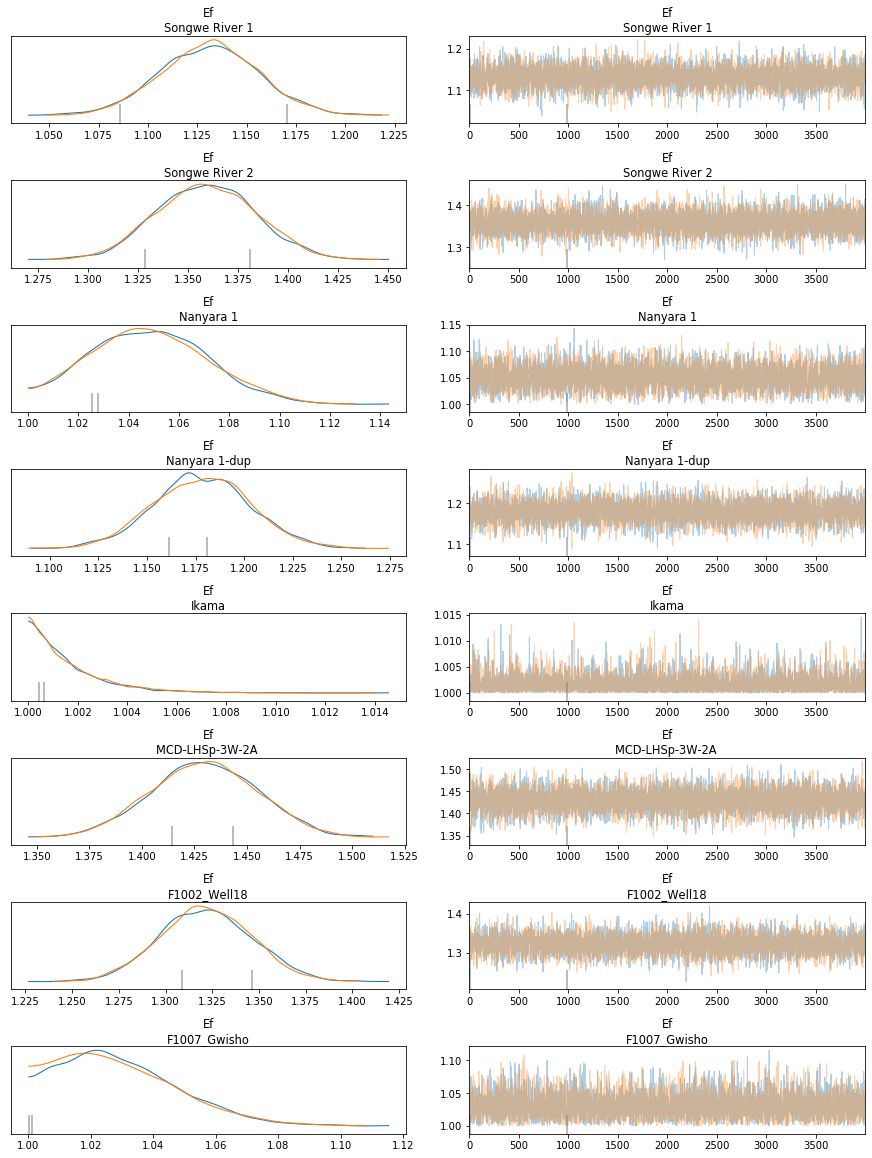

In [96]:
az.plot_trace(model_result3, var_names=['Ef'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000198C684C708>],
      dtype=object)

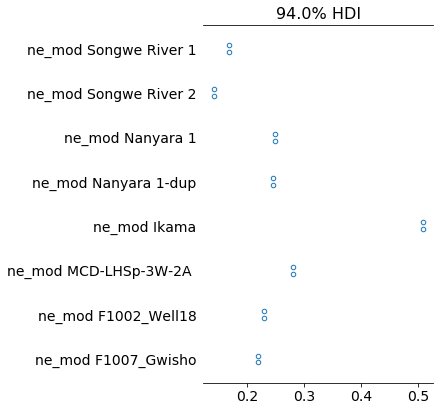

In [34]:
az.plot_forest(model_result2, kind='forestplot' ,var_names=['ne_mod'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C5A7640F48>,
      dtype=object)

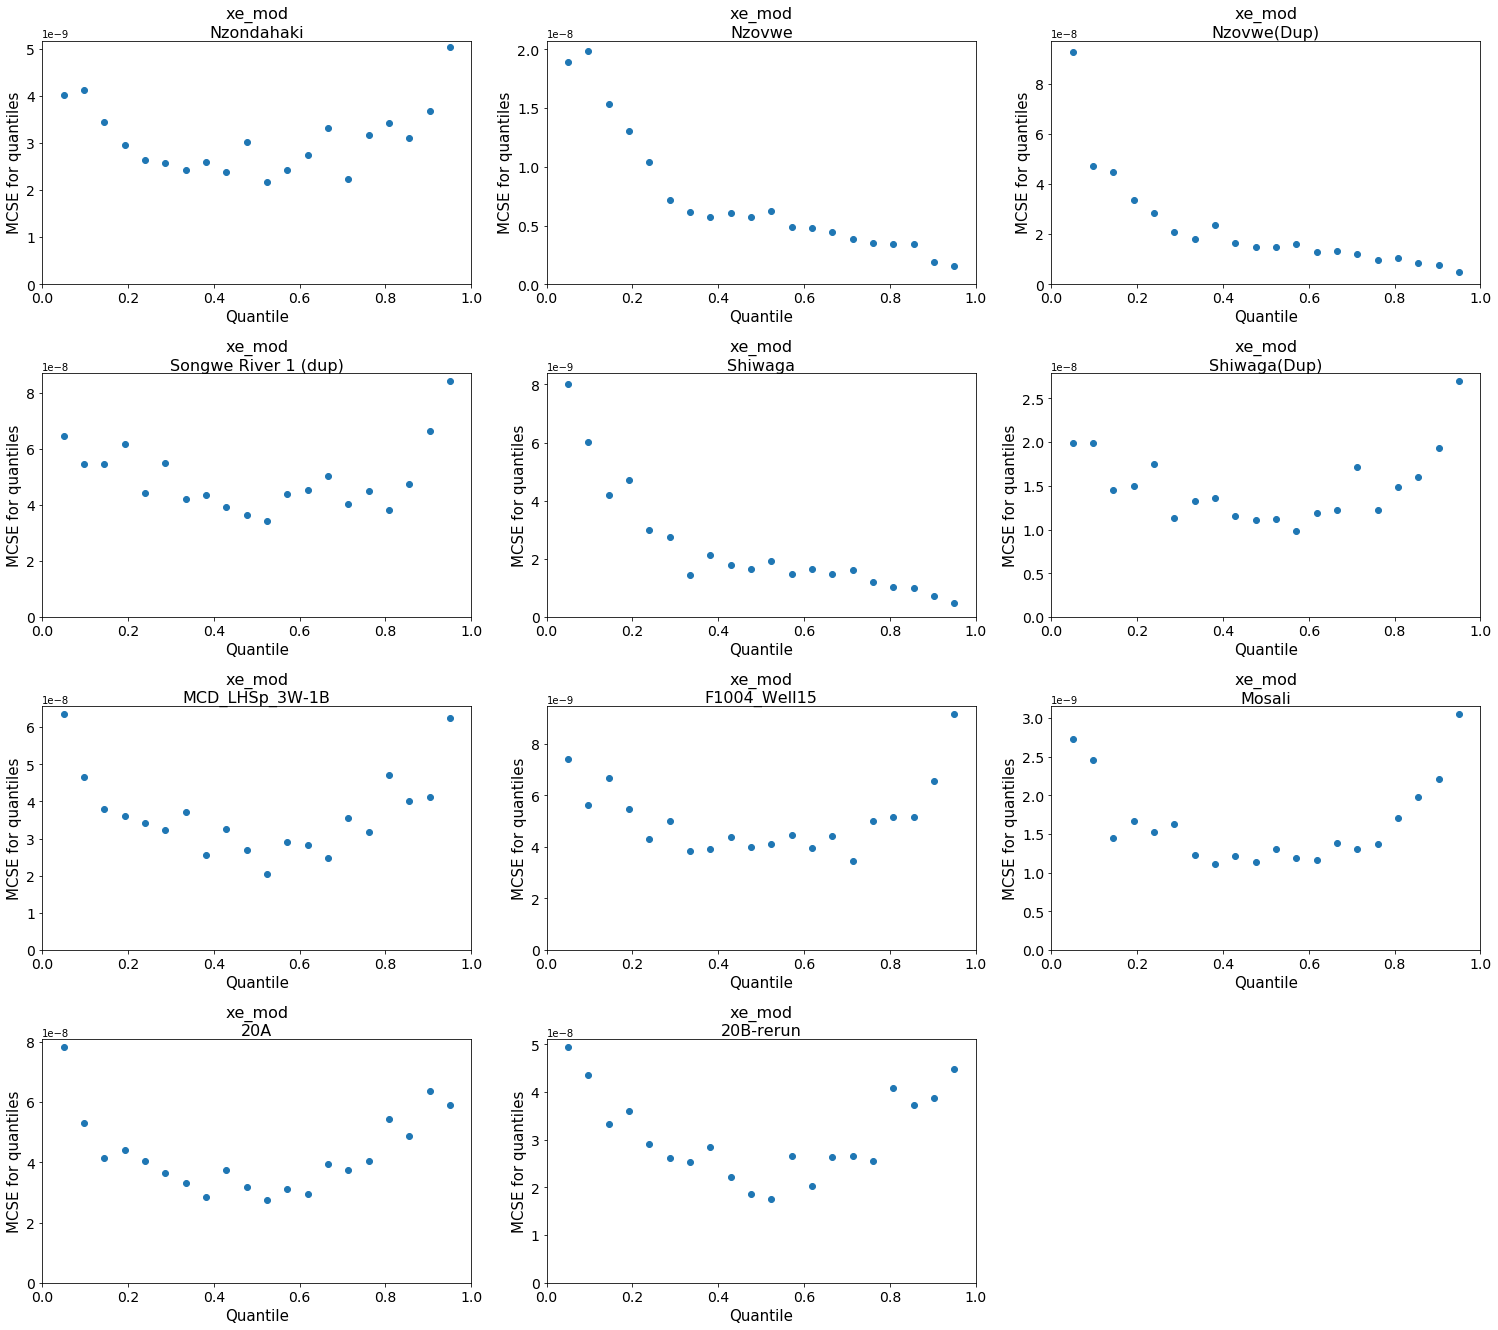

In [21]:
az.plot_mcse(model_result, var_names=['xe_mod'])

In [56]:
az.plot_dist_comparison(az_sum_z.xe_mod, kind='latent')

AttributeError: 'DataFrame' object has no attribute 'xe_mod'

In [28]:
print(KrAr)

<xarray.DataArray 'KrAr_d' (sample_id: 8)>
array([0.04519882, 0.05421375, 0.04185702, 0.0471047 , 0.02496805,
       0.05702607, 0.0528005 , 0.04082373])
Coordinates:
  * sample_id  (sample_id) object 'Songwe River 1' ... 'F1007_Gwisho'


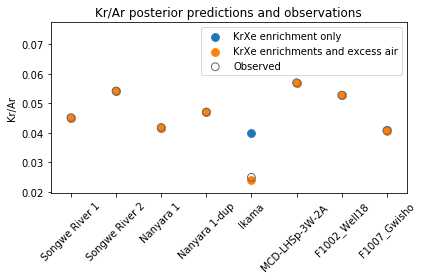

In [106]:
KrAr3 = model_result3.constant_data.KrAr_d
post3 = model_result3.posterior.assign_coords(KrAr3=KrAr3)
avg_kr3 = post3['kr_mod'].mean(dim=('chain', 'draw'))
avg_kr_hdi3 = az.hdi(post3, var_names="kr_mod")["kr_mod"]

KrAr4 = model_result4.constant_data.KrAr_d
post4 = model_result4.posterior.assign_coords(KrAr3=KrAr3)
avg_kr4 = post4['kr_mod'].mean(dim=('chain', 'draw'))
avg_kr_hdi4 = az.hdi(post4, var_names="kr_mod")["kr_mod"]

#KrAr3 = model_result3.constant_data.KrAr_d
#post3 = model_result3.posterior.assign_coords(KrAr3=KrAr3)
#avg_kr3 = post3['kr_mod'].mean(dim=('chain', 'draw'))
#avg_kr_hdi3 = az.hdi(post3, var_names="kr_mod")["kr_mod"]

fig, ax = plt.pyplot.subplots()

#ax.vlines(airf.index,
#    avg_kr_hdi.sel(hdi="lower"),
#    avg_kr_hdi.sel(hdi="higher"),
#    alpha=0.5,
#    color="deepskyblue", linewidth=2, label='95% HDI'
#)


ax.scatter(x=dataframe.index, y=avg_kr3, s=60, label='KrXe enrichment only')
ax.scatter(x=dataframe.index, y=avg_kr4, s=60, label='KrXe enrichments and excess air')
ax.scatter(x=dataframe.index, y=dataframe['84Kr/36Ar'], facecolor='none', edgecolor='dimgray', s=60, label='Observed')
#ax.scatter(x=dataframe.index, y=avg_kr3, s=60, label='KrXe enrichment')



ax.set(title= 'Kr/Ar posterior predictions and observations', ylabel="Kr/Ar")

ax.tick_params(axis = 'x', rotation=45)
ax.legend()
fig.tight_layout()
#plt.savefig('porosity_he_prior11.png', dpi=300)

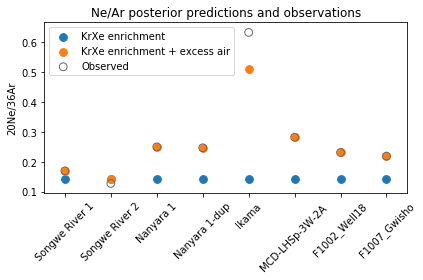

In [105]:
#NeAr3 = model_result3.constant_data.NeAr_d
#post_ne3 = model_result3.posterior.assign_coords(NeAr3=NeAr3)
#avg_ne3 = post_ne3['ne_mod'].mean(dim=('chain', 'draw'))
#avg_ne_hdi3 = az.hdi(post_ne3, var_names="ne_mod")["ne_mod"]

#NeAr2 = model_result2.constant_data.NeAr_d
post_ne4 = model_result4.posterior.assign_coords(NeAr3=NeAr3)
avg_ne4 = post_ne4['ne_mod'].mean(dim=('chain', 'draw'))
avg_ne_hdi4 = az.hdi(post_ne4, var_names="ne_mod")["ne_mod"]

ne_no_model = np.repeat(0.1434, 8)

#NeAr3 = model_result3.constant_data.NeAr_d
#post_ne3 = model_result3.posterior.assign_coords(NeAr=NeAr)
#avg_ne3 = post_ne3['ne_mod'].mean(dim=('chain', 'draw'))
#avg_ne_hdi3 = az.hdi(post_ne3, var_names="ne_mod")["ne_mod"]

fig, ax = plt.pyplot.subplots()

#ax.vlines(airf.index,
#    avg_kr_hdi.sel(hdi="lower"),
#    avg_kr_hdi.sel(hdi="higher"),
#    alpha=0.5,
#    color="deepskyblue", linewidth=2, label='95% HDI'
#)


ax.scatter(x=dataframe.index, y=ne_no_model, s=60, label='KrXe enrichment')
ax.scatter(x=dataframe.index, y=avg_ne4, s=60, label='KrXe enrichment + excess air')
ax.scatter(x=dataframe.index, y=dataframe['20Ne/36Ar'], facecolor='none', edgecolor='dimgray', s=60, label='Observed')
#ax.scatter(x=airf.index, y=avg_ne3, s=60, label='Excess air+temp')



ax.set(title= 'Ne/Ar posterior predictions and observations', ylabel="20Ne/36Ar")

ax.tick_params(axis = 'x', rotation=45)
ax.legend()
fig.tight_layout()
#plt.savefig('porosity_he_prior11.png', dpi=300)


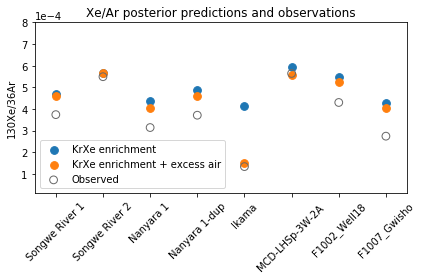

In [109]:
XeAr3 = model_result3.constant_data.XeAr_d
post_xe3 = model_result3.posterior.assign_coords(XeAr3=XeAr3)
avg_xe3 = post_xe3['xe_mod'].mean(dim=('chain', 'draw'))
avg_xe_hdi3 = az.hdi(post_xe3, var_names="xe_mod")["xe_mod"]


post_xe4 = model_result4.posterior.assign_coords(XeAr3=XeAr3)
avg_xe4 = post_xe4['xe_mod'].mean(dim=('chain', 'draw'))
avg_xe_hdi4 = az.hdi(post_xe4, var_names="xe_mod")["xe_mod"]


#post_xe3 = model_result3.posterior.assign_coords(XeAr=XeAr)
#avg_xe3 = post_xe3['xe_mod'].mean(dim=('chain', 'draw'))
#avg_xe_hdi3 = az.hdi(post_xe, var_names="xe_mod")["xe_mod"]

fig, ax = plt.pyplot.subplots()

#ax.vlines(airf.index,
#    avg_kr_hdi.sel(hdi="lower"),
#    avg_kr_hdi.sel(hdi="higher"),
#    alpha=0.5,
#    color="deepskyblue", linewidth=2, label='95% HDI'
#)


ax.scatter(x=dataframe.index, y=avg_xe3, s=60, label='KrXe enrichment')
ax.scatter(x=dataframe.index, y=avg_xe4, s=60, label='KrXe enrichment + excess air')
ax.scatter(x=dataframe.index, y=dataframe['130Xe/36Ar'], facecolor='none', edgecolor='dimgray', s=60, label='Observed')
#ax.scatter(x=airf.index, y=avg_xe3, s=60, label='Excess air+temp')



ax.set(title= 'Xe/Ar posterior predictions and observations', ylabel="130Xe/36Ar")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylim(1e-5, 0.8e-3)

ax.tick_params(axis = 'x', rotation=45)
ax.legend()
fig.tight_layout()
#plt.savefig('porosity_he_prior11.png', dpi=300)

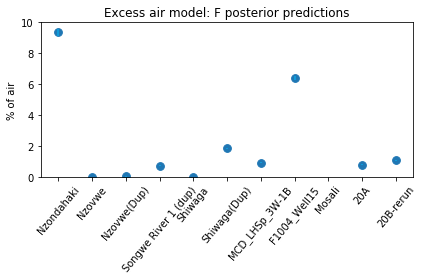

In [66]:
posterior = model_result2.posterior
avg_f = posterior['F'].mean(dim=('chain', 'draw'))
avg_f_hdi = az.hdi(posterior, var_names="F")["F"]*100


fig, ax = plt.pyplot.subplots()

ax.scatter(x=sample_id, y=avg_f*100,s=60, label='Posterior mean')

ax.vlines(sample_id,
    avg_f_hdi.sel(hdi="lower"),
    avg_f_hdi.sel(hdi="higher"),
    alpha=0.5,
    color="deepskyblue", linewidth=2, label='95% HDI'
)

ax.set(title= 'Excess air model: F posterior predictions', ylabel="% of air")
ax.set_ylim(0, 10)
ax.tick_params(axis = 'x', rotation=50)
#ax.legend()
fig.tight_layout()
#plt.savefig('porosity_phi_prior11.png', dpi=300)

In [194]:
#calculating degassing depth for samples model 2 temp 15C excess air
air = [1.77e-7, 1.17e-6, 4.56e-8, 4.59e-10] # ne ar kr xe at 15C 0 salinity

Ne = np.array(post_ne2['ne_mod'].mean(dim=('chain', 'draw')))
Kr = np.array(post_ne2['kr_mod'].mean(dim=('chain', 'draw')))
Xe = np.array(post_ne2['xe_mod'].mean(dim=('chain', 'draw')))
F = np.array(post_ne2['F'].mean(dim=('chain', 'draw')))

ne_corr = airf['20Ne'] - F*air[0]
ar_corr = airf['36Ar'] - F*air[1]
kr_corr = airf['84Kr'] - F*air[2]
xe_corr = airf['130Xe'] - F*air[3]

stack1 = pd.concat([ne_corr,ar_corr, kr_corr, xe_corr, airf['N2'], airf['Temp']], axis=1)
#T = np.array(post_ne['T'].mean(dim=('chain', 'draw')))

print(stack1)


                              20Ne          36Ar          84Kr         130Xe  \
Sample_ID                                                                      
Nzondahaki            1.269971e-06  3.122969e-06  8.499247e-08  5.856666e-10   
Nzovwe                1.950000e-07  1.439222e-06  5.600000e-08  5.781747e-10   
Nzovwe(Dup)           1.320000e-07  9.037134e-07  3.570000e-08  3.420614e-10   
Songwe River 1 (dup)  8.959219e-09  4.485680e-08  1.689799e-09  1.501235e-11   
Shiwaga               1.370000e-08  1.577277e-07  3.520000e-09  3.920085e-11   
Shiwaga(Dup)          2.629553e-08  1.008923e-07  4.438849e-09  3.752436e-11   
MCD_LHSp_3W-1B        1.022594e-05  4.848630e-05  1.679073e-06  1.399641e-08   
F1004_Well15          1.270627e-05  3.397973e-05  1.108648e-06  7.383951e-09   
Mosali                1.473850e-05  2.895432e-05  6.681468e-07  4.382821e-09   
20A                   1.954058e-06  9.588771e-06  3.537086e-07  3.285681e-09   
20B-rerun             2.340652e-06  1.06

In [190]:
#print(airf['N2'])
#print(ne_corr)

stack1 = pd.concat([ne_corr,ar_corr, kr_corr, xe_corr, airf['N2'], airf['Temp']], axis=1)
print(stack1)


                              20Ne          36Ar          84Kr         130Xe  \
Sample_ID                                                                      
Nzondahaki            1.269971e-06  3.122969e-06  8.499247e-08  5.856666e-10   
Nzovwe                1.950000e-07  1.439222e-06  5.600000e-08  5.781747e-10   
Nzovwe(Dup)           1.320000e-07  9.037134e-07  3.570000e-08  3.420614e-10   
Songwe River 1 (dup)  8.959219e-09  4.485680e-08  1.689799e-09  1.501235e-11   
Shiwaga               1.370000e-08  1.577277e-07  3.520000e-09  3.920085e-11   
Shiwaga(Dup)          2.629553e-08  1.008923e-07  4.438849e-09  3.752436e-11   
MCD_LHSp_3W-1B        1.022594e-05  4.848630e-05  1.679073e-06  1.399641e-08   
F1004_Well15          1.270627e-05  3.397973e-05  1.108648e-06  7.383951e-09   
Mosali                1.473850e-05  2.895432e-05  6.681468e-07  4.382821e-09   
20A                   1.954058e-06  9.588771e-06  3.537086e-07  3.285681e-09   
20B-rerun             2.340652e-06  1.06

In [122]:
print(az.hdi(post_ne, var_names="ne_mod")["ne_mod"])

<xarray.DataArray 'ne_mod' (sample_id: 11, hdi: 2)>
array([[0.40432489, 0.40804471],
       [0.18314101, 0.18319995],
       [0.183141  , 0.18321446],
       [0.19714981, 0.20084868],
       [0.183141  , 0.18317133],
       [0.25643553, 0.26020469],
       [0.20873183, 0.21227933],
       [0.37124007, 0.37495527],
       [0.50683251, 0.51048695],
       [0.2013021 , 0.20499431],
       [0.21808234, 0.22178454]])
Coordinates:
  * sample_id  (sample_id) object 'Nzondahaki' 'Nzovwe' ... '20A' '20B-rerun'
    NeAr       (sample_id) float64 0.4066 0.1355 0.1461 ... 0.509 0.2038 0.2202
  * hdi        (hdi) <U6 'lower' 'higher'


In [74]:
print(NeAr_d1)
print(dataframe['20Ne'])

[0.40663912 0.13548986 0.146064   0.19972376 0.08685855 0.2605976
 0.2109038  0.37393605 0.50899786 0.20378601 0.22024071]
Sample_ID
Nzondahaki              1.270000e-06
Nzovwe                  1.950000e-07
Nzovwe(Dup)             1.320000e-07
Songwe River 1 (dup)    8.960000e-09
Shiwaga                 1.370000e-08
Shiwaga(Dup)            2.630000e-08
MCD_LHSp_3W-1B          1.022595e-05
F1004_Well15            1.270629e-05
Mosali                  1.473884e-05
20A                     1.954059e-06
20B-rerun               2.340654e-06
Name: 20Ne, dtype: float64


In [77]:

# create excel writer object
writer = pd.ExcelWriter('krxe_excess_and_air_2006.xlsx')
# write dataframe to excel
az_sum_z3.to_excel(writer)
# save the excel
writer.save()

In [195]:
writer = pd.ExcelWriter('stack1.xlsx')

stack1.to_excel(writer)
writer.save()

TypeError: __init__() takes 1 positional argument but 2 were given

In [11]:
def debug(t, F):
    

        #t = pm.Normal('t', 273.15+15, 5,  dims='sample_id')
        #t= 273.15+15
        #Ef =pm.Normal('Ef', 1, 1,  dims='sample_id')
        #F = pm.Normal('F',0.01, 1,dims='sample_id')
        #Ef=2
        #F=0
        

        #NeAr_d = pm.Data("NeAr_d", NeAr_d1, dims=("sample_id"))
        #KrAr_d = pm.Data("KrAr_d", KrAr_d1, dims=("sample_id"))
        #eAr_d = pm.Data("XeAr_d", XeAr_d1, dims=("sample_id"))




        Na=0

        h=0

        # Setchenow coefficients for solublity dependence on salinity Smith and Kennedy (1983) (ones in the bible are slightly different)
        She = (-9.6723) + (14.4725) / (t / 100) + 4.6188 * np.log(t / 100)
        Sne = (-11.525) + (17.7408) / (t / 100) + 5.3421 * np.log(t / 100)
        Sar = (-10.271) + (16.095) / (t / 100) + 4.7539 * np.log(t / 100)
        Skr = (-9.5534) + (15.1039) / (t / 100) + 4.4164 * np.log(t / 100)
        Sxe = (-14.1338) + (21.8772) / (t / 100) + 6.5527 * np.log(t / 100)
        S = np.array([She, Sne, Sar, Skr, Sxe])

        # salinity constant Sr = e^S*Na
        Sr = np.exp(S * Na)

        # Humidity correction assuming 100% humidity at the water-air exchange surface PH20 is in mTorr. 760 mTorr = 1 atm
        #PH2O = np.exp((-5375.83583 / t) + 21.2023734)

        # Altitude correction P=P0exp(-h/8350)
        p_corr = (np.exp(-h/8350))
        #water vapour correction
        PH2O = np.exp((-5375.83583 / t) + 21.2023734)
        v_corr = (760 - PH2O)/760


        #Vapour pressure calculations wagner et puss 1993

        Pc=0.022064
        a1=-7.85951783
        a2=1.84408259
        a3=-11.7866497
        a4=22.6807411
        a5=-15.9618719
        a6=1.80122502
        Tc=647.096 #Critical point of water
       
        #Tr = Tc/t
        t1 = 1-(t/Tc)


        Tr = t/Tc
        t2 = (1-Tr)

        #vapour pressure in GPA
        P=Pc*np.exp((Tc/t)*((a1*t1)+(a2*(t1**1.5))+(a3*(t1**3))+(a4*(t1**3.5))+(a5*(t1**4))+(a6*(t1**7.5))))


        #Henry K Fernandez-Prini et al 2003. 5x3 matrix flipped to be 3x5. He, Ne, Ar, Kr, Xe coefficients in separate columns
        FK = np.array([[-3.52839, 7.12983, 4.4777],
             [-3.18301, 5.31448, 5.43774],
             [-8.40954, 4.29587, 10.52779],
             [-8.97358,3.61508,11.29963],
                [-14.21635,4.00041,15.60999]])

        air = [5.24e-6, 1.645e-5, 3.142e-5, 6.498e-7, 3.54e-9 ]

        #Henry K in atm and corrected for salinity
        
        khe= (((P*np.exp(FK[0,0]/Tr+((FK[0,1]*t2**0.355/Tr)+FK[0,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sne * Na))
              / 0.000101325)/(p_corr*v_corr)
        
        kne= (((P*np.exp(FK[1,0]/Tr+((FK[1,1]*t2**0.355/Tr)+FK[1,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sne * Na)) / 0.000101325)/(p_corr*v_corr)
        kar= (((P*np.exp(FK[2,0]/Tr+((FK[2,1]*t2**0.355/Tr)+FK[2,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sar * Na)) / 0.000101325)/(p_corr*v_corr)
        kkr= (((P*np.exp(FK[3,0]/Tr+((FK[3,1]*t2**0.355/Tr)+FK[3,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Skr * Na)) / 0.000101325)/(p_corr*v_corr)
        kxe= (((P*np.exp(FK[4,0]/Tr+((FK[4,1]*t2**0.355/Tr)+FK[4,2]*Tr**(-0.41)*np.exp(t2))))*np.exp(Sxe * Na)) / 0.000101325)/(p_corr*v_corr)

        Ne_asw = air[1]/kne *22413.83/18.05
        Ar_asw = air[2]/kar *22413.83/18.05
        Kr_asw = air[3]/kkr *22413.83/18.05
        Xe_asw = air[4]/kxe *22413.83/18.05
        
        
        #arair = air[2]/air[1]
        #krair = air[3]/air[1]
        #xeair= air[4]/air[1]




        near=((Ne_asw + (air[1]*F))/(Ar_asw + (air[2]*F)))
        krar=((Kr_asw + (air[3]*F))/(Ar_asw + (air[2]*F))) 
        xear=((Xe_asw +(air[4] * F))/(Ar_asw + (air[2]*F))) 

        #ne_f = pm.Normal('ne_f', mu=ne_mod, sd=1, dims='sample_id', observed = NeAr_d)
        #kr_f = pm.Normal('kr_f', mu=kr_mod, sd=1e-3, dims='sample_id', observed = KrAr_d)
        #xe_f = pm.Normal('xe_f', mu=xe_mod, sd=1e-3, dims='sample_id', observed =XeAr_d)
        
        
        print(near, krar, xear)
        return 





 



debug(273.15+15, 1e-6)
debug(273.15+15, 1e-4)
debug(273.15+15, 1e-2)
debug(273.15+15, 0.02)
debug(273.15+15, 0.1)



0.15114418699205445 0.038991002595397804 0.00039215471013781246
0.1521345947603333 0.038942307911260646 0.0003914114206839401
0.23016105738455234 0.03510603554596071 0.00033285347248414055
0.2815201084286592 0.03258090110308031 0.0002943091049774921
0.42272324372416475 0.025638465580446277 0.00018833780236820322


In [54]:
from lmfit import Minimizer, Parameters, report_fit, fit_report, printfuncs, conf_interval, conf_interval2d
import lmfit
import csv
from scipy import stats

ModuleNotFoundError: No module named 'lmfit'

In [56]:
pip install lmfit

  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84397 sha256=c56fe54f60b4e5bfddf7ef0876e3c275ec90fed73c638a882697b909ddfccd81
  Stored in directory: c:\users\eart0477\appdata\local\pip\cache\wheels\b9\7a\d1\236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit
Note: you may need to restart the kernel to use updated packages.


In [53]:
model_result.posterior

<xarray.Dataset>
Dimensions:    (chain: 2, draw: 4000, sample_id: 11)
Coordinates:
  * chain      (chain) int32 0 1
  * draw       (draw) int32 0 1 2 3 4 5 6 ... 3993 3994 3995 3996 3997 3998 3999
  * sample_id  (sample_id) object 'Nzondahaki' 'Nzovwe' ... '20A' '20B-rerun'
Data variables:
    F_d        (chain, draw, sample_id) float64 0.2109 0.9998 ... 0.5812 0.4918
    ne_mod     (chain, draw, sample_id) float64 0.4062 0.1512 ... 0.202 0.2209
    kr_mod     (chain, draw, sample_id) float64 0.0129 0.03899 ... 0.02622
    xe_mod     (chain, draw, sample_id) float64 2.234e-05 0.000392 ... 0.0001559
Attributes:
    created_at:                 2022-06-20T13:26:43.212104
    arviz_version:              0.10.0
    inference_library:          pymc3
    inference_library_version:  3.9.3
    sampling_time:              23.82882332801819
    tuning_steps:               1000